# 예측 평가 
---
가정 : 현재의 년도는 2015년이다.

예측 년도 : 2022년

목표 : 실제 2022년 적절한 경로당 수와 오차 확인

# 2015년 부산 광역시 데이터 분석
___

사용 하는 데이터 목록 

1. 2015년 부산 인구 데이터
2. 2015년 부산 경로당 현황
3. 부산 경로당 이용률
4. 2015년 부산 행정 구역 정보

관련 라이브러리 import

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

차트 한글 깨짐 발생시 주석 해제 후 실행 -> 런타임 -> 런타임 재시작

In [42]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# 인구 현황, 경로당 현황 및 경로당 이용률 데이터 로드

2015년 부산 인구 현황 로드

In [43]:
df_population  = pd.read_csv("2015년 부산인구.csv",encoding='cp949')
df_population.head(5)

,행정구역(동읍면)별,합계,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100+,고령인구 합계
0,부산광역시,3513777,184875,140328,99313,54727,24401,7782,1715,1489,514630
1,중구,45816,3205,2635,1870,966,498,190,42,64,9470
2,중앙동,1789,142,102,81,40,20,13,2,3,403
3,동광동,3444,264,245,156,79,50,19,2,4,819
4,대청동,7540,479,379,275,154,92,26,7,6,1418


부산 경로당 이용률 로드

In [44]:
df_sc_members = pd.read_csv("경로당 등록자 수.csv",encoding='UTF-8')
df_sc_members.head(5)

,구분,경로당 1개소 당 등록자 수,전체 노인 중 경로당 이용 비율,전체 인구 중 노인 비율
0,중구,43.2,12.5,24.2
1,서구,26.2,7.6,22.8
2,동구,30.7,9.6,24.6
3,영도구,35.2,8.1,24.2
4,부산진구,31.9,15.0,17.8


2015년 부산 경로당 현황 로드

In [45]:
df_busan_senior_centers = pd.read_csv("경로당 현황_2015.csv",encoding='cp949')
df_busan_senior_centers.head(5)

,시설 명,주소,읍면동
0,구름다리,중구 법수길 76,보수동
1,금호타운,중구 영주로 49,보수동
2,대림에이스,중구 법수길 74,보수동
3,대청공원,중구 망양로 355번길 37,대청동
4,대청만우,중구 중구로 83,대청동


# 경로당 이용률을 통해 적절한 경로당 수 및 필요한 경로당 수 파악
___



## Main 데이터 프레임 생성
___
파악된 정보들을 Main 데이터 프레임에 적재함
Main 데이터 프레임은 최종 결과이다. 

In [46]:
# 부산 16개 행정 구
district = ["강서구", "금정구","기장군","남구","동구","동래구","부산진구","북구","사상구","사하구","서구","수영구","연제구","영도구","중구","해운대구"]

데이터 프레임 생성 메서드

행정 구 | 행정 동 | 경로당 수 | 적절한 경로당 수 | 필요한 경로당 수 | 

In [47]:
def get_senior_centers_by_district():
    '''
    구별로 시니어 센터를가져옴. 구2015.csv파일 읽음
    :return: 행정구 | 행정 동 | 경로당 수 | 적절한 경로당 수 | 필요한 경로당 수|
    '''
    df_temp = pd.DataFrame(columns=["경로당 수", "적절한 경로당 수", "필요한 경로당 수"])
    #  구, 동에 대한 정보 불러옴
    df_district = pd.read_csv("구2015.csv", encoding='cp949')
    df = pd.concat([df_district , df_temp])

    return df

## 행정 동 단위 고령인구 파악 및 서브 데이터 프레임으로 관리

추후 행정 동에 대한 경로당 필요성을 파악하기 위한 밑작업

In [48]:
def get_senior_people_by_admin_area(district):
    '''
    행정구역별 고령인구 가져옴
    :return: 행정구역별 | 고령인구 합계
    '''
    lst_df = [df_population["행정구역(동읍면)별"],df_population["고령인구 합계"]]

    df_sc = pd.concat(lst_df,axis=1)
    lst = []
    for i in range(1,222): # 222 : number_of_record
        for d in district:
            if df_sc.iloc[i]["행정구역(동읍면)별"] == d:
                lst.append(i)

    for i in lst:
        df_sc.drop(index=i,axis=0,inplace=True) # 행정 구 삭제
    df_sc .drop(index=0,inplace=True)  # 부산광역시 전체 삭제
    df_sc.set_index("행정구역(동읍면)별",inplace=True) # 동을 기준으로 함
    return df_sc.copy()

In [49]:
df_senior_people = get_senior_people_by_admin_area(district)
df_senior_people.head(5)

,고령인구 합계
행정구역(동읍면)별,
중앙동,403
동광동,819
대청동,1418
보수동,2232
부평동,1235


In [50]:
df_old_population_count  = df_senior_people.sort_index()
df_old_population_count.head(5)

,고령인구 합계
행정구역(동읍면)별,
가덕도동,868
가락동,766
가야1동,3374
가야2동,3034
감만1동,2799


## 행정 동 단위 적절한 경로당 수 파악
___

이용률을 고려한 행정 동 단위 적절한 경로당 수 파악 및 필요한 경로당 수 파악

### 노인 1명당 필요한 경로당 수 산출 메서드

In [51]:
def oen_old_population_senior_centers_request_by_member(df_sc_members):
    '''
    이용률을 고려한 1명의 노인당 필요한 경로당 개수를 구하여 경로당 이용률 데이터 프레임에 삽입
    :param df_sc_members: 경로당 이용률 데이터 프레임
    :return: 1명의 노인이 필요한 경로당 수
    '''

    sc_members_rate = df_sc_members.iloc[0:]["전체 노인 중 경로당 이용 비율"] # A
    sc_member_n = df_sc_members.iloc[0:]["경로당 1개소 당 등록자 수"] # B
    result = (sc_members_rate/100) / sc_member_n
    df = pd.concat([df_sc_members,result],axis=1)
    df.rename(columns={0:'노인 1명이 필요한 경로당 개수'},inplace=True)

    return df

In [52]:
df_sc_members = oen_old_population_senior_centers_request_by_member(df_sc_members)
df_request_member_main = get_senior_centers_by_district()
district = list(df_request_member_main.iloc[0:]["행정 구"])
df_request_member_main = df_request_member_main.set_index(["행정 구","행정 동"])

In [53]:
df_sc_members

,구분,경로당 1개소 당 등록자 수,전체 노인 중 경로당 이용 비율,전체 인구 중 노인 비율,노인 1명이 필요한 경로당 개수
0,중구,43.2,12.5,24.2,0.002894
1,서구,26.2,7.6,22.8,0.002901
2,동구,30.7,9.6,24.6,0.003127
3,영도구,35.2,8.1,24.2,0.002301
4,부산진구,31.9,15.0,17.8,0.004702
5,동래구,39.8,13.0,16.6,0.003266
6,남구,34.0,10.0,17.9,0.002941
7,북구,29.9,10.4,14.5,0.003478
8,해운대구,39.9,14.2,15.3,0.003559
9,사하구,26.5,9.3,16.1,0.003509


In [54]:
df_request_member_main

경로당 수 적절한 경로당 수 필요한 경로당 수
행정 구 행정 동                          
중구   중앙동    NaN       NaN       NaN
     동광동    NaN       NaN       NaN
     대청동    NaN       NaN       NaN
     보수동    NaN       NaN       NaN
     부평동    NaN       NaN       NaN
...         ...       ...       ...
기장군  기장읍    NaN       NaN       NaN
     장안읍    NaN       NaN       NaN
     정관읍    NaN       NaN       NaN
     일광면    NaN       NaN       NaN
     철마면    NaN       NaN       NaN

[205 rows x 3 columns]

### 행정 동 단위 적절한 경로당 수 산출 메서드

In [55]:
df_sc_members

,구분,경로당 1개소 당 등록자 수,전체 노인 중 경로당 이용 비율,전체 인구 중 노인 비율,노인 1명이 필요한 경로당 개수
0,중구,43.2,12.5,24.2,0.002894
1,서구,26.2,7.6,22.8,0.002901
2,동구,30.7,9.6,24.6,0.003127
3,영도구,35.2,8.1,24.2,0.002301
4,부산진구,31.9,15.0,17.8,0.004702
5,동래구,39.8,13.0,16.6,0.003266
6,남구,34.0,10.0,17.9,0.002941
7,북구,29.9,10.4,14.5,0.003478
8,해운대구,39.9,14.2,15.3,0.003559
9,사하구,26.5,9.3,16.1,0.003509


In [56]:
def old_population_sum_by_admin_area_advance(df_request_member_main,df_senior_people,df_sc_members):
    '''
    행정 동 별 적절한 경로당 수를 구한다.
    :param df_request_member_main: 이용률을 고려한 데이터를 담을 df
    :param df_senior_people: 행정 동 단위 고령인구
    :param df_sc_members: 노인 1명당 필요한 경로당 개수 정보
    :return: 적절한 경로당 수가 추가된 데이터 프레임
    '''
    df_sc_members.set_index("구분",inplace=True)
    appropriate_data = np.array([])
    dong_n = df_senior_people.shape[0]
    gu_n = df_sc_members.shape[0]
    str_info = "고령인구 합계"
    for i in range(0,gu_n):
        for j in range(0,dong_n):
            if df_request_member_main.index[j][0] == df_sc_members.index[i]:
                appropriate_data= np.append(
                    appropriate_data,
                    round(df_sc_members.iloc[i]["노인 1명이 필요한 경로당 개수"]*df_senior_people.iloc[j][str_info],1)
                )
                #print(f"result[i]:{df_sc_members.index[i]} 고령:{df_senior_people.iloc[j][str_info]} ")

    df_request_member_main["적절한 경로당 수"] = appropriate_data
    return df_request_member_main

In [57]:
df_request_member_main= old_population_sum_by_admin_area_advance(
    df_request_member_main,
    df_senior_people,
    df_sc_members
)

In [58]:
df_request_member_main

경로당 수  적절한 경로당 수 필요한 경로당 수
행정 구 행정 동                           
중구   중앙동    NaN        1.2       NaN
     동광동    NaN        2.4       NaN
     대청동    NaN        4.1       NaN
     보수동    NaN        6.5       NaN
     부평동    NaN        3.6       NaN
...         ...        ...       ...
기장군  기장읍    NaN      101.6       NaN
     장안읍    NaN       23.0       NaN
     정관읍    NaN       60.9       NaN
     일광면    NaN       25.5       NaN
     철마면    NaN       21.0       NaN

[205 rows x 3 columns]

### 행정 동 단위 필요한 경로당 수 산출 메서드

In [59]:
def senior_center_need_counts_by_admin_area_advance(df_busan_senior_centers,df_request_member_main):
    '''
    행정 동 단위 이용률을 고려한 경로당 개수를 구한다
    :param df_busan_senior_centers: 부산시 경로당 현황 데이터
    :param df_request_member_main:  이용률을 고려한 데이터를 담을 df
    :return: 행정 동 단위 이용률을 고려한 경로당 개수를 담은 df
    '''
    sc_n_by_admin_area = np.array(df_busan_senior_centers["읍면동"].value_counts().sort_index()) # 201
    non_data = ['광복동', '당감1동', '범천4동', '장전3동', '중앙동']
    df_request_member_main.reset_index(inplace=True)
    df_request_member_main.sort_values(by=["행정 동"],inplace=True)
    df_request_member_main["경로당 수"] = sc_n_by_admin_area
    for non in non_data:
        df_request_member_main.loc[df_request_member_main.iloc[0:]["행정 동"]==non,"경로당 수"] = 0
    df_request_member_main["필요한 경로당 수"] = round(-(df_request_member_main["경로당 수"] - df_request_member_main["적절한 경로당 수"]),0)
    # df_request_member_main.set_index(["행정 구"],inplace=True)

    return df_request_member_main

In [60]:
df_request_member_main = senior_center_need_counts_by_admin_area_advance(df_busan_senior_centers, df_request_member_main)
df_request_member_main.head(5)

,행정 구,행정 동,경로당 수,적절한 경로당 수,필요한 경로당 수
165,강서구,가덕도동,14,9.9,-4.0
163,강서구,가락동,15,8.7,-6.0
58,부산진구,가야1동,1,15.9,15.0
59,부산진구,가야2동,8,14.3,6.0
89,남구,감만1동,11,8.2,-3.0


### 필요한 경로당 수 추출 메서드
---
미래의 증설될 경로당 수 파악을 위해 현재의 필요한 경로당 수를 따로 분리

In [61]:
def extract_by_district_necessary_senior_center(df_request_member_main):
    '''
    df_request_member_main에서 행정 구, 행정 동, 필요한 경로당 수를 추출하여 새로운 데이터 프레임을 생성한다.
    :param df_request_member_main: 추출할 데이터가 들어잇는 데이터 프레임
    :return: 추출된 데이터를 가질 데이터 프레임
    '''
    df = df_request_member_main.sort_index()
    df.drop(columns=["경로당 수","적절한 경로당 수"],axis=1,inplace=True)
    return df

In [62]:
df_extract_main = extract_by_district_necessary_senior_center(df_request_member_main)
df_extract_main.head(5)

,행정 구,행정 동,필요한 경로당 수
0,중구,중앙동,1.0
1,중구,동광동,1.0
2,중구,대청동,-1.0
3,중구,보수동,-4.0
4,중구,부평동,2.0


# 2001년 ~ 2022년 고령인구 비율 및 증감율 파악
---
KOSIS에서 제공하는 자료를 참고하여 고령인구 비율 및 증감율을 파악한다.

## 고령인구 비율 및 증감율 데이터 로드

In [63]:
rate_df = pd.read_csv("부산-비율.csv")
rate_df

,2001,2001.1,2002,2002.1,2003,2003.1,2004,2004.1,2005,2005.1,...,2017,2017.1,2018,2018.1,2019,2019.1,2020,2020.1,2021,2021.1
0,원데이터,전년 대비 증감,원데이터,전년 대비 증감,원데이터,전년 대비 증감,원데이터,전년 대비 증감,원데이터,전년 대비 증감,...,원데이터,전년 대비 증감,원데이터,전년 대비 증감,원데이터,전년 대비 증감,원데이터,전년 대비 증감,원데이터,전년 대비 증감
1,6.4,0.4,6.8,0.4,7.3,0.5,7.8,0.5,8.3,0.5,...,16.3,1,17.1,0.8,18.2,1.1,19.4,1.2,20.4,1.0


## 고령인구 비율 및 증감율 리스트 변환

In [64]:
orginal = []
last = []
row_n = rate_df.shape[1]

for i in range(0,row_n):
    if i % 2 == 0:
        orginal.append(rate_df.iloc[1][i])
    else:
        last.append(rate_df.iloc[1][i])
orginal = list(map(float,orginal))
last = list(map(float,last))

# 미래 고령인구 파악
---

2015년의 데이터와 우리가 만든 수식을 사용하여 미래 고령인구 비율, 고령인구 증가율 산출

$ FOP_{rate}(a,b,c,k_{time sapn}) = e^{b+ax}+c $
----

$ k_{time sapn} = Y_{예측년도} - 2001 $

$ a = ln(2022년\, 고령인구\, /\, 2001년\, 고령인구) \ / \ (2022 - 2001) $

$ b = ln(2001년\, 고령인구\, /\, a) $

$ c = 2001년\, 고령인구\, 비율\, -\, e^b $



## 미래 고령인구 비율 및 증가율 산출 메서드

In [65]:
def future_old_population_rate_method(PGR_2001, Old_rate_2001, PGR_2022, x):
    '''
    미래 고령인구 비율 f(x) = np.exp(b+a*x)+c
    미래 고령인구 증가율 f'(x) = a*np.exp(b+a*x)
    :param PGR_2001 : 2001년 고령인구 증가율
    :param Old_rate_2001 : 2001년 고령인구 비율
    :param PGR_2022 : 2022년 고령인구 증가율
    :param x : 미래 년도 - 2001
    :return: f(x), f'(x)
    '''
    x = x - 2001
    a = np.log(PGR_2022/PGR_2001) / 21
    b = np.log(PGR_2001/a)
    c = (Old_rate_2001-np.exp(b))
    fx = round(np.exp(b+(a*x))+c, 3)
    fx_dot  = round(a*np.exp(b+(a*x)), 3)
    print(f"고령인구 비율 : {fx}%, 고령인구 증가율 : {fx_dot}%")

    return  fx,fx_dot

In [66]:
PGR_2001 = last[0]
Old_rate_2001 = orginal[0]
PGR_2022 = last[-1] ## PGR_2022로 변경
T = 2022 ## 2022년 예측하기
future_old_population_rate,increase_old_population_rate = future_old_population_rate_method(PGR_2001, Old_rate_2001, PGR_2022, T) ## 2022년 고령인구 비율 예측

고령인구 비율 : 20.151%, 고령인구 증가율 : 1.0%


## 증가될 고령인구 산출 메서드

In [67]:
def predict_future_old_population(future_old_population_rate,df_population):
    '''
    예측된 미래 고령인구 비율을 이용하여 증가될 고령인구 수를 구한다
    :param future_old_population_rate: 미래 고령인구 비율
    :param df_population: 현재 인구 데이터
    :return: 미래 증가될 고령인구 수
    '''
    df = pd.DataFrame(columns=["행정 구","행정 동","증가될 인구","증가될 경로당 수"])
    future_old_population =  (future_old_population_rate / 100) * df_population.iloc[0]["합계"] # 증가된 고령 인구 수
    predict_future_old_population = round(future_old_population -  df_population.iloc[0]["고령인구 합계"])  # 증가될 고령 인구수 (증가된 고령 인구 - 현재 고령 인구)

    return predict_future_old_population

In [68]:
future_old_population_by_busan = predict_future_old_population(future_old_population_rate,df_population)
future_old_population_by_busan

193431

## 미래 행정 동 단위 고령 인구 파악


미래 데이터를 저장할 새로운 데이터 프레임 생성

In [69]:
df_future_main =  get_senior_centers_by_district()
df_future_main.head(5)

,행정 구,행정 동,경로당 수,적절한 경로당 수,필요한 경로당 수
0,중구,중앙동,NaN,NaN,NaN
1,중구,동광동,NaN,NaN,NaN
2,중구,대청동,NaN,NaN,NaN
3,중구,보수동,NaN,NaN,NaN
4,중구,부평동,NaN,NaN,NaN


## 행정동 단위 고령인구 산출 

$ (행정\, 동\, 단위\, 고령인구\, 합계\, / \,부산\, 전체\, 고령인\, 합계)\, *\, 미래\, 증가될\, 고령인구 $

In [70]:
predict_future_old_population_by_admin_area = (
        (df_old_population_count.iloc[0:]["고령인구 합계"] / df_population.iloc[0]["고령인구 합계"]) * future_old_population_by_busan).reset_index()
predict_future_old_population_by_admin_area.head(5)

,행정구역(동읍면)별,고령인구 합계
0,가덕도동,326.250137
1,가락동,287.911987
2,가야1동,1268.165855
3,가야2동,1140.372023
4,감만1동,1052.043933


# 미래 경로당 수 파악
___

미래의 행정 동 단위 적절한 경로당 수 산출

$ 노인\, 1명당\, 필요한\, 경로당\, 수\, * 미래\, 행정동\, 단위\, 증가될\, 고령인구\, $

## 미래 행정 동 단위 적절한 경로당 수 산출 메서드

In [71]:
 def future_old_population_sum_by_admin_area_advance_2(df_future_main,predict_future_old_population_by_admin_area,df_sc_members):
    '''
    미래의 행정 동 별 적절한 경로당 수를 구한다.
    :param df_future_main: 이용률을 고려한 데이터를 담을 df
    :param predict_future_old_population_by_admin_area: 미래 행정 동 단위 증가될 고령인구
    :param df_sc_members: 노인 1명당 필요한 경로당 개수 정보
    :return: 적절한 경로당 수가 추가된 데이터 프레임
    '''

    admin_area_n = df_sc_members.shape[0] # 행정 동 개수 205
    gu_n = predict_future_old_population_by_admin_area.shape[0] # 행정 구 개수 16개
    df_future_main.set_index(["행정 구"],inplace=True)
    district = ["강서구", "금정구","기장군","남구","동구","동래구","부산진구","북구","사상구","사하구","서구","수영구","연제구","영도구","중구","해운대구"]

    i = 0;
    for d in district:
        df_future_main.loc[d,["노인 1명당 필요한 경로당 개수"]] = df_sc_members.loc[d]["노인 1명이 필요한 경로당 개수"]
        i += 1;

    # 행정 동 적절한 경로당 수 구함

    df_future_main.reset_index(inplace=True)
    df_future_main = df_future_main.set_index("행정 동").sort_index()
    predict_future_old_population_by_admin_area.set_index("행정구역(동읍면)별",inplace=True)

    lst1 = np.array(df_future_main.iloc[0:]["노인 1명당 필요한 경로당 개수"])
    lst2 = np.array(predict_future_old_population_by_admin_area.iloc[0:]["고령인구 합계"])

    mul = lst1 * lst2
    mul = mul.astype(int)
    df_future_main["적절한 경로당 수"] = mul

    return df_future_main

In [72]:
df_future_main = future_old_population_sum_by_admin_area_advance_2(df_future_main,predict_future_old_population_by_admin_area,df_sc_members)


## 미래 증가될 인구, 필요한 경로당 수 및 증가될 경로당 수 산출 메서드

In [73]:
def complete_it(df_future_main,predict_future_old_population_by_admin_area,df_extract_main):
    '''
    증가될 인구 및 미래 필요한 경로당 수, 증가될 경로당 수를 산출하여 리턴한다.
    :param df_future_main: 미래의 데이터를 가짐
    :param predict_future_old_population_by_admin_area: 미래의 고령인구
    :param df_extract_main: 현재의 필요한 경로당 수가 추출된 데이터
    :return: 행정 동 | 행정 구 | 증가될 경로당 수 | 미래 필요한 경로당 수 | 노인 1명당 필요한 경로당 개수 | 증가될 인구
    '''
    df_future_main["증가될 인구"] = round(predict_future_old_population_by_admin_area.iloc[0:]["고령인구 합계"], 0).astype(int)
    df_future_main = df_future_main.drop(columns=["경로당 수"])
    df_future_main = df_future_main.rename(columns={"필요한 경로당 수": "미래 필요한 경로당 수", "적절한 경로당 수": "증가될 경로당 수"})
    df_extract_main = df_extract_main.set_index("행정 동").sort_index()
    # 미래의 적절한 경로당 + 현재의 필요한 경로당 수
    df_future_main["미래 필요한 경로당 수"] = df_future_main.iloc[0:]["증가될 경로당 수"] + df_extract_main.iloc[0:]["필요한 경로당 수"]

    return df_future_main

In [74]:
df_future_main = complete_it(df_future_main,predict_future_old_population_by_admin_area,df_extract_main)
df_future_main.head(5)

,행정 구,증가될 경로당 수,미래 필요한 경로당 수,노인 1명당 필요한 경로당 개수,증가될 인구
행정 동,,,,,
가덕도동,강서구,3,-1.0,0.011369,326
가락동,강서구,3,-3.0,0.011369,288
가야1동,부산진구,5,20.0,0.004702,1268
가야2동,부산진구,5,11.0,0.004702,1140
감만1동,남구,3,0.0,0.002941,1052


# 실제 2022년 경로당 수와 예측한 필요한 경로당 수 비교
---

미래 필요한 경로당 수가 실제 2022년에 반영이 되었는지 확인을 해봄으로써, 예측 결과를 평가 할 수 있다.

## 실제 2022년 행정 동 경로당 수 로드

In [75]:
df_compare = pd.read_csv("예측비교.csv",encoding='cp949').set_index("행정 동").sort_index()
df_compare.head(5)

,행정 구,경로당 수,적절한 경로당 수,필요한 경로당 수
행정 동,,,,
가덕도동,강서구,17,13.4,-4
가락동,강서구,18,10.6,-7
가야1동,부산진구,15,20.4,5
가야2동,부산진구,12,18.3,6
감만1동,남구,15,10.1,-5


## 예측 된 적절한 경로당 수와 실제 적절한 경로당 수 비교하여 오차 계산
---
$ 2015년의\, 설치된\, 경로당\, 수\, +\, 미래\, 필요한\, 경로당\, 수$의 값과 2022년의 적절한 경로당 수를 비교한다.

In [76]:
def percentage_err(df_request_member_main,df_future_main,df_compare):
    '''
    백분율 오차를 구하여 반환하는 메서드
    :param df_request_member_main: 2015년 경로당 수
    :param df_future_main: 미래 필요한 경로당 수
    :param df_compare: 실제 2022년 적절한 경로당 수
    :return: 백분율 오차
    '''
    prediction_data = df_future_main.iloc[0:]["미래 필요한 경로당 수"]
    fact_data = df_request_member_main.iloc[0:]["경로당 수"] 
    prediction_data = int(prediction_data.sum()) + int(fact_data.sum()) # 예측 대이터

    compare_data = df_compare.iloc[0:]["적절한 경로당 수"]
    compare_data = int(compare_data.sum()) # 비교 대상

    ##백분율 오차 계산
    percentage_error = abs(compare_data - prediction_data)/compare_data * 100

    return percentage_error,prediction_data,compare_data

In [77]:
percentage_error,prediction_data,compare_data = percentage_err(df_request_member_main,df_future_main,df_compare)
print(f"실제 2022년 적절한 경로당 수와 예측한 값의 백분율 오차: {percentage_error}%")

실제 2022년 적절한 경로당 수와 예측한 값의 백분율 오차: 1.368849426563078%


# 예측 결과 시각화

In [78]:
# seaborn 한글 설정
sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [79]:
def draw_compare_data(prediction_data,compare_data):
    '''
    비교한 데이터 시각화 메서드
    :param prediction_data: 
    :param compare_data: 
    :return: 차트
    '''

    df = pd.DataFrame({"data":[prediction_data,compare_data]},index=["예측 데이터","비교 데이터"])

    plt.figure(figsize=(5,5))
    sns.barplot(x=df.index,y="data",data = df,hue = "data")
    plt.title("예측 데이터와 실제 적절한 경로당 수 비교")
    plt.ylabel("적절한 경로당 수")
    plt.yticks([i for i in range(0,3000,200)])
    
    return plt.show()

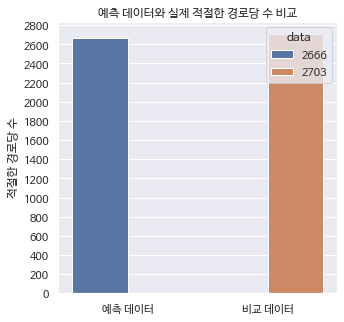

In [80]:
draw_compare_data(prediction_data,compare_data)